* Author : Ameni MTIBAA
* This work was done as part of the "Machine learning on Big Data" class at Paris-Dauphine University
* This work was originally done on the Databricks Community Edition platform.
---------------------------------------------------------------------------------------------------------------------
This document is intended for studying the most common Gradient Descent optimizers through the implementation of each one of them from scratch, using python and spark. The following algorithms have been implemented.

- **Gradient Descent**
- **Batch Gradient Descent**
- **Stochastic Gradient Descent**
- **Gradient Descent with Momentum**
- **Gradient Descent with Nesterov Momentum**
- **AdaGrad**
- **RMSProp**
- **AdaDelta**
- **Adam**
- **AdaMax**
- **NAdam**

Each of these optimizers has been coded in a simple way so that it is easy to gain intuition about how they work in a distributed setting and what are the improvements over the base algorithm (vanilla Gradient Descent).

## Initialization

In [3]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pprint import pprint
from IPython.display import Image
import numpy as np
import time
from sklearn.preprocessing import StandardScaler

In [4]:
houses = fetch_california_housing()
print("features names : ")
pprint(list(houses.feature_names))
samples = houses.data.shape[0]
X = houses.data[:int((0.85) * samples), :]
Y = houses.target[:int((0.85) * samples)]
X_test = houses.data[int((0.85) * samples):, :]
Y_test = houses.target[int((0.85) * samples):]

features names : 
['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [5]:
data = np.concatenate((X,Y[:,None]),axis=1)
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)
print(data.shape)
n = X.shape[0] 
d = X.shape[1] 
print("Number of examples : ", n)
print("Number of features : ", d)
X = data[:,:-1]
y = data[:,-1].reshape(-1,1)

(17544, 9)
Number of examples : 17544
Number of features : 8

## Optimizers implementation

The next subsections show several implementations of the most used optimizers of the last years, from the simplest one (vanilla Gradient Descent) until the state-of-the-art improvements.

### Vanilla Gradient Descent

In [9]:
  def gradient_descent_computation(data, W):
    global error
    X = data[:-1]
    targets = data[-1]
    predictions = np.dot(X, W) 
    err = predictions - targets
    gradient = np.dot(X.T,  err) 
    # Compute Squared Error
    err = (np.sum(targets - predictions))**2
    # Add error to accumulator variable
    error.add(err)
    return gradient

In [10]:
print(" *********** Start ************ ")
print(" *********** Batch Gradient Descent ************ ")

t_start = time.time()

rdd = sc.parallelize(data) 
w = np.zeros(X.shape[1])
lr = 1e-1 # step-size 
n_iter = 25 # number of iteration
GD_history = []
error = sc.accumulator(0)
print(" ------ Start training ------ ")
w_br = sc.broadcast(w)

for i in range(n_iter):
    
    error = sc.accumulator(0)
     # compute gradient for all data points
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    # sum all gradients
    grad = grad.reduce(lambda x,y : (x+y)) / n 
    # compute MSE
    loss = error.value/n
    GD_history.append(loss)
    w -= lr * grad # perform Vanilla GD
    w_br = sc.broadcast(w) 
    print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** Batch Gradient Descent ************ 
 ------ Start training ------ 
Iteration : 0/25 ; Loss = 1.0000
Iteration : 1/25 ; Loss = 0.9030
Iteration : 2/25 ; Loss = 0.8255
Iteration : 3/25 ; Loss = 0.7632
Iteration : 4/25 ; Loss = 0.7131
Iteration : 5/25 ; Loss = 0.6725
Iteration : 6/25 ; Loss = 0.6396
Iteration : 7/25 ; Loss = 0.6128
Iteration : 8/25 ; Loss = 0.5908
Iteration : 9/25 ; Loss = 0.5728
Iteration : 10/25 ; Loss = 0.5580
Iteration : 11/25 ; Loss = 0.5457
Iteration : 12/25 ; Loss = 0.5355
Iteration : 13/25 ; Loss = 0.5270
Iteration : 14/25 ; Loss = 0.5199
Iteration : 15/25 ; Loss = 0.5138
Iteration : 16/25 ; Loss = 0.5087
Iteration : 17/25 ; Loss = 0.5043
Iteration : 18/25 ; Loss = 0.5005
Iteration : 19/25 ; Loss = 0.4972
Iteration : 20/25 ; Loss = 0.4943
Iteration : 21/25 ; Loss = 0.4917
Iteration : 22/25 ; Loss = 0.4894
Iteration : 23/25 ; Loss = 0.4873
Iteration : 24/25 ; Loss = 0.4855
 *********** Ended in ************ 9.754826545715332

Notice that Since we are not modifying 'w', and to avoid wasting storage, we can broadcast it so that it only gets sent to each machine a single time

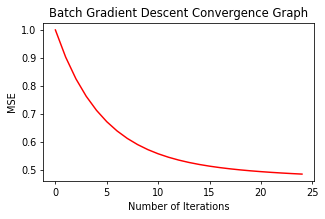

In [12]:
figure(num=None, figsize=(5, 3), dpi=70, facecolor='w', edgecolor='r')
plt.plot(range(len(GD_history)), GD_history, 'r')
plt.title("Batch Gradient Descent Convergence Graph")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.show()

### Mini Batch Gradient Descent

In [14]:
print(" *********** Start ************ ")
print(" *********** Mini Batch Gradient Descent ************ ")

t_start = time.time()

rdd = sc.parallelize(data) 

# data repartition
# nb_repartition = 3 * Number of cores
nb_repartition = 6 
RDDdata = rdd.repartition(nb_repartition).cache() 
# creates an RDD of tuples, one tuple per partition
RDDdata = RDDdata.glom()
# index the partitions
RDDdata = RDDdata.zipWithIndex()

w = np.zeros(X.shape[1])
lr = 1e-1
n_iter = 25 
mini_GD_history = []
error = sc.accumulator(0)
print(" ------ Start training ------ ")
ts = time.time()
w_br = sc.broadcast(w)
for i in range(n_iter):
  loss = 0
  for j in range(nb_repartition):
    error = sc.accumulator(0)
    # select data batch
    partition_rdd = RDDdata.filter(lambda x:x[1] == j).flatMap(lambda x: x[0]) 
    batch_size = partition_rdd.count()
     # compute gradient for each batch : partition_rdd
    grad = partition_rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    # sum all gradients
    grad = grad.reduce(lambda x,y : (x+y))/batch_size
    # compute MSE
    loss += error.value
    w -= lr * grad 
    w_br = sc.broadcast(w) 
  loss /= n
  mini_GD_history.append(loss)
  print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )


*********** Start ************ 
 *********** Mini Batch Gradient Descent ************ 
 ------ Start training ------ 
Iteration : 0/25 ; Loss = 0.8129
Iteration : 1/25 ; Loss = 0.5868
Iteration : 2/25 ; Loss = 0.5185
Iteration : 3/25 ; Loss = 0.4938
Iteration : 4/25 ; Loss = 0.4821
Iteration : 5/25 ; Loss = 0.4746
Iteration : 6/25 ; Loss = 0.4687
Iteration : 7/25 ; Loss = 0.4637
Iteration : 8/25 ; Loss = 0.4593
Iteration : 9/25 ; Loss = 0.4552
Iteration : 10/25 ; Loss = 0.4516
Iteration : 11/25 ; Loss = 0.4483
Iteration : 12/25 ; Loss = 0.4452
Iteration : 13/25 ; Loss = 0.4424
Iteration : 14/25 ; Loss = 0.4399
Iteration : 15/25 ; Loss = 0.4376
Iteration : 16/25 ; Loss = 0.4355
Iteration : 17/25 ; Loss = 0.4335
Iteration : 18/25 ; Loss = 0.4318
Iteration : 19/25 ; Loss = 0.4301
Iteration : 20/25 ; Loss = 0.4287
Iteration : 21/25 ; Loss = 0.4273
Iteration : 22/25 ; Loss = 0.4261
Iteration : 23/25 ; Loss = 0.4249
Iteration : 24/25 ; Loss = 0.4239
 *********** Ended in ************ 47.8033390045166

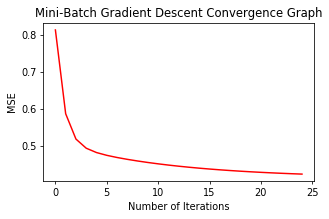

In [15]:
figure(num=None, figsize=(5, 3), dpi=70, facecolor='w', edgecolor='r')
plt.plot(range(len(mini_GD_history)), mini_GD_history, 'r')
plt.title("Mini-Batch Gradient Descent Convergence Graph")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.show()

### Stochastic Gradient Descent

In [17]:
print(" *********** Start ************ ")
print(" *********** Stochastic Gradient Descent ************ ")

t_start = time.time()

w = np.zeros(X.shape[1])
lr = 1e-1 # step-size 
n_iter = 25 # number of iteration
SGD_history = []
error = sc.accumulator(0)
print(" ------ Start training ------ ")
w_br = sc.broadcast(w)

for i in range(n_iter):
  loss = 0
  for samples in range (n):
    rdd = sc.parallelize(data[samples:samples+1]) 
    error = sc.accumulator(0)
     # compute gradient for a single data points
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    # sum all gradients
    grad = grad.reduce(lambda x,y : (x+y)) / n 
    # compute MSE
    loss += error.value
    w -= lr * grad 
    w_br = sc.broadcast(w) 
  loss /= n
  SGD_history.append(loss)
  print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

The difference between SGD and GD: gradient descent is more expensive in work but requires fewer iterations. On the other hand SGD requires less work per iteration, but instead requires more iterations which can take huge time.
This make SGD not well suited for Spark.

### Gradient Descent with Momentum

In [20]:
print(" *********** Start ************ ")
print(" *********** Gradient Descent with Momentum ************ ")
t_start = time.time()

rdd = sc.parallelize(data) 
w = np.zeros(X.shape[1])
lr = 1e-1 
n_iter = 25 
momentum_GD = []
vt = 0
gamma = 0.6
error = sc.accumulator(0)
w_br = sc.broadcast(w)

print(" ------ Start training ------ ")
for i in range(n_iter):
    error = sc.accumulator(0)
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    grad = grad.reduce(lambda x,y : (x+y)) / n 
    loss = error.value/n
    momentum_GD.append(loss)
    vt = gamma * vt + lr * grad 
    w = w - vt
    w_br = sc.broadcast(w)
    print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** Gradient Descent with Momentum ************ 
 ------ Start training ------ 
Iteration : 0/25 ; Loss = 1.0000
Iteration : 1/25 ; Loss = 0.9030
Iteration : 2/25 ; Loss = 0.7784
Iteration : 3/25 ; Loss = 0.6692
Iteration : 4/25 ; Loss = 0.5910
Iteration : 5/25 ; Loss = 0.5423
Iteration : 6/25 ; Loss = 0.5148
Iteration : 7/25 ; Loss = 0.5004
Iteration : 8/25 ; Loss = 0.4928
Iteration : 9/25 ; Loss = 0.4883
Iteration : 10/25 ; Loss = 0.4851
Iteration : 11/25 ; Loss = 0.4822
Iteration : 12/25 ; Loss = 0.4794
Iteration : 13/25 ; Loss = 0.4766
Iteration : 14/25 ; Loss = 0.4740
Iteration : 15/25 ; Loss = 0.4715
Iteration : 16/25 ; Loss = 0.4691
Iteration : 17/25 ; Loss = 0.4669
Iteration : 18/25 ; Loss = 0.4648
Iteration : 19/25 ; Loss = 0.4628
Iteration : 20/25 ; Loss = 0.4609
Iteration : 21/25 ; Loss = 0.4590
Iteration : 22/25 ; Loss = 0.4573
Iteration : 23/25 ; Loss = 0.4556
Iteration : 24/25 ; Loss = 0.4540
 *********** Ended in ************ 9.56572937965393

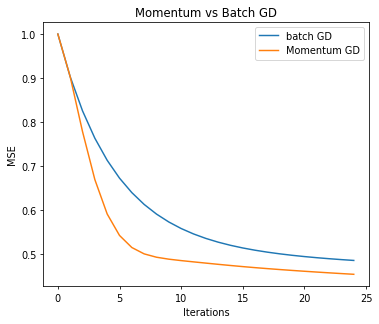

In [21]:
#Batch vs momentum

figure(num=None, figsize=(6, 5), dpi=70, facecolor='w', edgecolor='r')
plt.plot(GD_history, label = 'batch GD')
plt.plot(momentum_GD, label = 'Momentum GD')
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('Momentum vs Batch GD')
plt.legend();


As shown in the figure, this approach outperforms the vanilla version. The momentum addition makes the algorithm converge faster due to the cumulative momentum when the slope is slow; it produces a momentum accumulation in this direction, which helps the algorithm arrive faster to the global minimum. 
It turns into a very interesting exercise to increase/decrease the momentum term \\(\gamma\\) to see how the system behaves.

###Nesterov accelerated gradient

Gradient Descent with Nesterov Momentum is a simple modification over the Gradient descent with momentum algorithm. It tries to correct the oscilations produced by the inertia of the momentum by simply, instead of summing the momentum vector to the negative gradient vector, computing the gradient from the point where the momentum vector ends so that its trajectory is totally or partially corrected.

In [25]:
print(" *********** Start ************ ")
print(" *********** Nesterov accelerated gradient ************ ")
t_start = time.time()

rdd = sc.parallelize(data) 
w = np.zeros(X.shape[1])
lr = 1e-1  
n_iter = 25 
Nestrov_GD = []
vt = 0
gamma = 0.7
error = sc.accumulator(0)
w_br = sc.broadcast(w)
print(" ------ Start training ------ ")
for i in range(n_iter):
    error = sc.accumulator(0)
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    grad = grad.reduce(lambda x,y : (x+y)) / n 
    loss = error.value/n
    Nestrov_GD.append(loss)   
    vt = gamma * vt + lr * grad 
    w = w - vt
    broad = w - gamma * vt
    w_br = sc.broadcast(broad)
    print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** Nesterov accelerated gradient ************ 
 ------ Start training ------ 
Iter : [0/25] ; Loss = 1.000
Iter : [1/25] ; Loss = 0.842
Iter : [2/25] ; Loss = 0.702
Iter : [3/25] ; Loss = 0.603
Iter : [4/25] ; Loss = 0.543
Iter : [5/25] ; Loss = 0.511
Iter : [6/25] ; Loss = 0.496
Iter : [7/25] ; Loss = 0.489
Iter : [8/25] ; Loss = 0.486
Iter : [9/25] ; Loss = 0.482
Iter : [10/25] ; Loss = 0.479
Iter : [11/25] ; Loss = 0.476
Iter : [12/25] ; Loss = 0.472
Iter : [13/25] ; Loss = 0.468
Iter : [14/25] ; Loss = 0.465
Iter : [15/25] ; Loss = 0.462
Iter : [16/25] ; Loss = 0.460
Iter : [17/25] ; Loss = 0.457
Iter : [18/25] ; Loss = 0.455
Iter : [19/25] ; Loss = 0.453
Iter : [20/25] ; Loss = 0.451
Iter : [21/25] ; Loss = 0.449
Iter : [22/25] ; Loss = 0.447
Iter : [23/25] ; Loss = 0.445
Iter : [24/25] ; Loss = 0.443
 ------ End training ------ 
 Execution time : 9.45797324180603

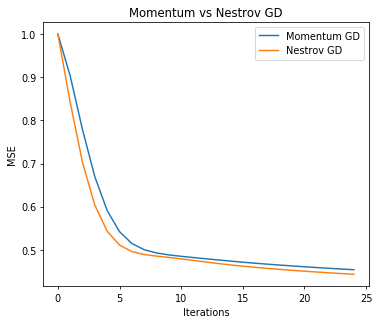

In [26]:
#Nestrov vs momentum

figure(num=None, figsize=(6, 5), dpi=70, facecolor='w', edgecolor='r')
plt.plot(momentum_GD, label = 'Momentum GD')
plt.plot(Nestrov_GD, label = 'Nestrov GD')
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('Momentum vs Nestrov GD')
plt.legend();


###Adagrad

In [28]:
print(" *********** Start ************ ")
print(" *********** Adagrad ************ ")
t_start = time.time()

w = np.zeros(X.shape[1])
g_sum = np.zeros(X.shape[1])
stepsize = 1e-1  
n_iter = 25
history_adagrad = []
error = sc.accumulator(0)
rdd = sc.parallelize(data) 
w_br = sc.broadcast(w)
epsilon = 1e-8 
gti=0 

for i in range(n_iter):
    error = sc.accumulator(0)
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    grad = grad.reduce(lambda x,y : (x+y)) / n 
    loss = error.value/n
    history_adagrad.append(loss)
    gti+=grad**2
    adjusted_grad = grad / (epsilon + np.sqrt(gti))
    w -= stepsize*adjusted_grad
    w_br = sc.broadcast(w)
    print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** Adagrad ************ 
Iteration : 0/25 ; Loss = 1.0000
Iteration : 1/25 ; Loss = 0.8148
Iteration : 2/25 ; Loss = 0.7132
Iteration : 3/25 ; Loss = 0.6540
Iteration : 4/25 ; Loss = 0.6145
Iteration : 5/25 ; Loss = 0.5859
Iteration : 6/25 ; Loss = 0.5644
Iteration : 7/25 ; Loss = 0.5474
Iteration : 8/25 ; Loss = 0.5335
Iteration : 9/25 ; Loss = 0.5220
Iteration : 10/25 ; Loss = 0.5123
Iteration : 11/25 ; Loss = 0.5039
Iteration : 12/25 ; Loss = 0.4967
Iteration : 13/25 ; Loss = 0.4903
Iteration : 14/25 ; Loss = 0.4847
Iteration : 15/25 ; Loss = 0.4796
Iteration : 16/25 ; Loss = 0.4750
Iteration : 17/25 ; Loss = 0.4708
Iteration : 18/25 ; Loss = 0.4669
Iteration : 19/25 ; Loss = 0.4634
Iteration : 20/25 ; Loss = 0.4601
Iteration : 21/25 ; Loss = 0.4571
Iteration : 22/25 ; Loss = 0.4543
Iteration : 23/25 ; Loss = 0.4517
Iteration : 24/25 ; Loss = 0.4493
 *********** Ended in ************ 9.4553964138031

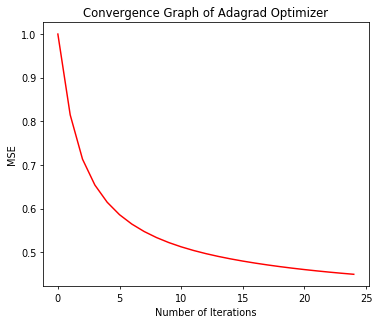

In [29]:
figure(num=None, figsize=(6, 5), dpi=70, facecolor='w', edgecolor='r')
plt.plot(range(len(history_adagrad)), history_adagrad, 'r')
plt.title("Convergence Graph of Adagrad Optimizer")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.show()

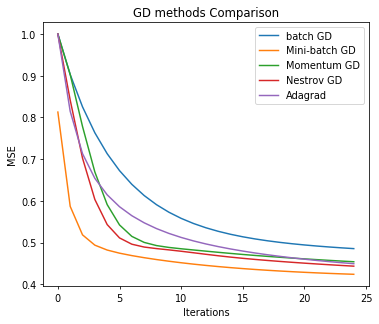

In [30]:
#Comparison
figure(num=None, figsize=(6, 5), dpi=70, facecolor='w', edgecolor='r')
plt.plot(GD_history, label = 'batch GD')
plt.plot(mini_GD_history, label = 'Mini-batch GD') 
plt.plot(momentum_GD, label = 'Momentum GD')
plt.plot(Nestrov_GD, label = 'Nestrov GD') 
plt.plot(history_adagrad, label = 'Adagrad')
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('GD methods Comparison')
plt.legend();

We can clearly see that the suggested methods are improving the performance of GD but still, Batch GD is outperforming them all.
We decided then to see how Nesterov GD performs in a mini-batch mode

###Mini-Batch Nesterov accelerated gradient

In [33]:
print(" *********** Start ************ ")
print(" *********** Mini-Batch Nesterov accelerated gradient ************ ")
t_start = time.time()

rdd = sc.parallelize(data) 
# data repartition
# nb_repartition = 3 * Number of cores
nb_repartition = 6 
RDDdata = rdd.repartition(nb_repartition).cache() 
# creates an RDD of tuples, one tuple per partition
RDDdata = RDDdata.glom()
# index the partitions
RDDdata = RDDdata.zipWithIndex()

w = np.zeros(X.shape[1])
lr = 1e-1  
n_iter = 25 
Mini_Batch_Nestrov_GD = []
vt = 0
gamma = 0.7
error = sc.accumulator(0)
w_br = sc.broadcast(w)

print(" ------ Start training ------ ")
for i in range(n_iter):
  loss = 0
  for j in range(nb_repartition):    
    error = sc.accumulator(0)
    # select data batch
    partition_rdd = RDDdata.filter(lambda x:x[1] == j).flatMap(lambda x: x[0]) ###
    batch_size = partition_rdd.count()
     # compute gradient for each batch partition
    grad = partition_rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    grad = grad.reduce(lambda x,y : (x+y)) / batch_size
    loss += error.value
    vt = gamma * vt + lr * grad 
    w = w - vt
    broad = w - gamma * vt
    w_br = sc.broadcast(broad)
  loss /= n
  Mini_Batch_Nestrov_GD.append(loss)
  print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** Mini-Batch Nesterov accelerated gradient ************ 
 ------ Start training ------ 
Iteration : 0/25 ; Loss = 0.6995
Iteration : 1/25 ; Loss = 0.4854
Iteration : 2/25 ; Loss = 0.4662
Iteration : 3/25 ; Loss = 0.4501
Iteration : 4/25 ; Loss = 0.4401
Iteration : 5/25 ; Loss = 0.4327
Iteration : 6/25 ; Loss = 0.4274
Iteration : 7/25 ; Loss = 0.4236
Iteration : 8/25 ; Loss = 0.4208
Iteration : 9/25 ; Loss = 0.4188
Iteration : 10/25 ; Loss = 0.4173
Iteration : 11/25 ; Loss = 0.4162
Iteration : 12/25 ; Loss = 0.4155
Iteration : 13/25 ; Loss = 0.4149
Iteration : 14/25 ; Loss = 0.4145
Iteration : 15/25 ; Loss = 0.4142
Iteration : 16/25 ; Loss = 0.4140
Iteration : 17/25 ; Loss = 0.4138
Iteration : 18/25 ; Loss = 0.4137
Iteration : 19/25 ; Loss = 0.4136
Iteration : 20/25 ; Loss = 0.4136
Iteration : 21/25 ; Loss = 0.4135
Iteration : 22/25 ; Loss = 0.4135
Iteration : 23/25 ; Loss = 0.4135
Iteration : 24/25 ; Loss = 0.4134
 *********** Ended in ************ 45.84519290924072

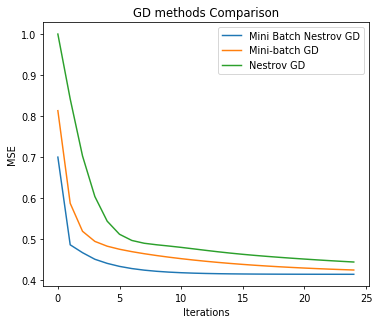

In [34]:
#Comparison
figure(num=None, figsize=(6, 5), dpi=70, facecolor='w', edgecolor='r')
plt.plot(Mini_Batch_Nestrov_GD, label = 'Mini Batch Nestrov GD')
plt.plot(mini_GD_history, label = 'Mini-batch GD') 
plt.plot(Nestrov_GD, label = 'Nestrov GD')
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('GD methods Comparison')
plt.legend();

As expected, Mini Batch Nestrov GD outperforms both Vanilla GD and Mini Batch GD.
For a fair comparison, we will implement the rest of the algorithms in a full batch mode.

### Adadelta

In [37]:
print(" *********** Start ************ ")
print(" *********** Adadelta ************ ")
t_start = time.time()

rdd = sc.parallelize(data)
w = np.zeros(X.shape[1])
delta_w = np.zeros(X.shape[1])
Eg_old = 0
Ed_old = 0
RMSg = 0
RMSd = 0
gamma = 0.9
n_iter = 25 
history_adadelta = []
error = sc.accumulator(0)
w_br = sc.broadcast(w)
epsilon = 1e-8
eta = 1e-3
for i in range(n_iter):
    error = sc.accumulator(0)
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value)) 
    grad = grad.reduce(lambda x,y : (x+y)) / n 
    loss = error.value/n
    history_adadelta.append(loss)
    Eg = gamma * Eg_old + (1-gamma) * grad**2
    RMSg = np.sqrt(Eg  + epsilon)
    delta_w -= (eta / RMSg) * grad
    Ed = gamma * Eg_old + (1-gamma) * delta_w**2
    RMSd = np.sqrt(Ed  + epsilon)
    w -= (RMSd / np.sqrt(Eg  + epsilon)) * grad
    Eg_old = Eg
    Ed_old = Ed
    w_br = sc.broadcast(w)
    print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** Adadelta ************ 
Iteration : 0/25 ; Loss = 1.0000
Iteration : 1/25 ; Loss = 0.9923
Iteration : 2/25 ; Loss = 0.5524
Iteration : 3/25 ; Loss = 0.4941
Iteration : 4/25 ; Loss = 0.4817
Iteration : 5/25 ; Loss = 0.4719
Iteration : 6/25 ; Loss = 0.4638
Iteration : 7/25 ; Loss = 0.4567
Iteration : 8/25 ; Loss = 0.4507
Iteration : 9/25 ; Loss = 0.4454
Iteration : 10/25 ; Loss = 0.4408
Iteration : 11/25 ; Loss = 0.4369
Iteration : 12/25 ; Loss = 0.4335
Iteration : 13/25 ; Loss = 0.4306
Iteration : 14/25 ; Loss = 0.4280
Iteration : 15/25 ; Loss = 0.4259
Iteration : 16/25 ; Loss = 0.4240
Iteration : 17/25 ; Loss = 0.4224
Iteration : 18/25 ; Loss = 0.4210
Iteration : 19/25 ; Loss = 0.4198
Iteration : 20/25 ; Loss = 0.4187
Iteration : 21/25 ; Loss = 0.4178
Iteration : 22/25 ; Loss = 0.4171
Iteration : 23/25 ; Loss = 0.4164
Iteration : 24/25 ; Loss = 0.4158
 *********** Ended in ************ 9.67829442024231

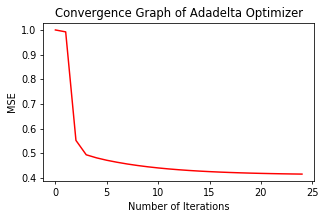

In [38]:
figure(num=None, figsize=(5, 3), dpi=70, facecolor='w', edgecolor='r')
plt.plot(range(len(history_adadelta)), history_adadelta, 'r')
plt.title("Convergence Graph of Adadelta Optimizer")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.show()

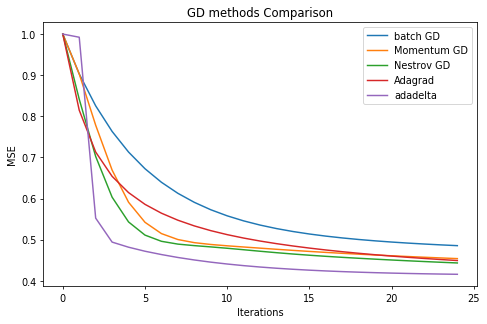

In [39]:
#Comparison
figure(num=None, figsize=(8, 5), dpi=70, facecolor='w', edgecolor='r')
plt.plot(GD_history, label = 'batch GD')
plt.plot(momentum_GD, label = 'Momentum GD')
plt.plot(Nestrov_GD, label = 'Nestrov GD') 
plt.plot(history_adagrad, label = 'Adagrad')
plt.plot(history_adadelta, label = 'adadelta')
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('GD methods Comparison')
plt.legend();

### RMSprop

In [41]:
print(" *********** Start ************ ")
print(" *********** RMSProp ************ ")
t_start = time.time()

w = np.zeros(X.shape[1])
delta = np.zeros(X.shape[1])
Eg = 0
gamma = 0.9
n_iter = 25 
history_rmsprop = []
error = sc.accumulator(0)
rdd = sc.parallelize(data) 
w_br = sc.broadcast(w)
epsilon = 1e-6
eta = 3e-2
for i in range(n_iter):  
    error = sc.accumulator(0)
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    grad = grad.reduce(lambda x,y : (x+y)) / n 
    loss = error.value/n
    history_rmsprop.append(loss)
    Eg = gamma * Eg + (1-gamma) * grad**2
    w -= (eta / np.sqrt(Eg  + epsilon)) * grad
    w_br = sc.broadcast(w)
    print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))     
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** RMSProp ************ 
Iteration : 0/25 ; Loss = 1.0000
Iteration : 1/25 ; Loss = 0.8213
Iteration : 2/25 ; Loss = 0.7203
Iteration : 3/25 ; Loss = 0.6591
Iteration : 4/25 ; Loss = 0.6169
Iteration : 5/25 ; Loss = 0.5858
Iteration : 6/25 ; Loss = 0.5624
Iteration : 7/25 ; Loss = 0.5437
Iteration : 8/25 ; Loss = 0.5281
Iteration : 9/25 ; Loss = 0.5148
Iteration : 10/25 ; Loss = 0.5035
Iteration : 11/25 ; Loss = 0.4937
Iteration : 12/25 ; Loss = 0.4853
Iteration : 13/25 ; Loss = 0.4778
Iteration : 14/25 ; Loss = 0.4711
Iteration : 15/25 ; Loss = 0.4651
Iteration : 16/25 ; Loss = 0.4597
Iteration : 17/25 ; Loss = 0.4549
Iteration : 18/25 ; Loss = 0.4509
Iteration : 19/25 ; Loss = 0.4475
Iteration : 20/25 ; Loss = 0.4446
Iteration : 21/25 ; Loss = 0.4426
Iteration : 22/25 ; Loss = 0.4407
Iteration : 23/25 ; Loss = 0.4382
Iteration : 24/25 ; Loss = 0.4345
 *********** Ended in ************ 9.246913194656372

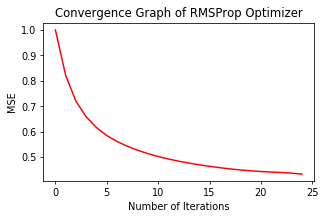

In [42]:
figure(num=None, figsize=(5, 3), dpi=70, facecolor='w', edgecolor='r')
plt.plot(range(len(history_rmsprop)), history_rmsprop, 'r')
plt.title("Convergence Graph of RMSProp Optimizer")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.show()

###Adam

In [44]:
print(" *********** Start ************ ")
print(" *********** Adam ************ ")
t_start = time.time()

rdd = sc.parallelize(data)
w = np.zeros(X.shape[1])
delta = np.zeros(X.shape[1])
m_old = 0
v_old = 0
eta = 1e-2
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
n_iter = 25
history_adam = []
error = sc.accumulator(0)
w_br = sc.broadcast(w)

for i in range(n_iter):
    error = sc.accumulator(0)
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value)) # compute gradient full batch
    grad = grad.reduce(lambda x,y : (x+y)) / n # sum all gradients
    loss = error.value/n
    history_adam.append(loss)
    m = b1 * m_old + (1-b1) * grad 
    v = b2 * v_old + (1-b2) * grad**2
    m_hat = m / (1 - b1)
    v_hat = v / (1 - b1)
    w -= (eta / (np.sqrt(v_hat) + epsilon)) * m_hat
    v_old = v
    m_old = m
    w_br = sc.broadcast(w)
    print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** Adam ************ 
Iteration : 0/25 ; Loss = 1.0000
Iteration : 1/25 ; Loss = 0.8148
Iteration : 2/25 ; Loss = 0.6302
Iteration : 3/25 ; Loss = 0.5289
Iteration : 4/25 ; Loss = 0.5156
Iteration : 5/25 ; Loss = 0.5444
Iteration : 6/25 ; Loss = 0.5777
Iteration : 7/25 ; Loss = 0.5832
Iteration : 8/25 ; Loss = 0.5588
Iteration : 9/25 ; Loss = 0.5147
Iteration : 10/25 ; Loss = 0.4701
Iteration : 11/25 ; Loss = 0.4386
Iteration : 12/25 ; Loss = 0.4329
Iteration : 13/25 ; Loss = 0.4483
Iteration : 14/25 ; Loss = 0.4697
Iteration : 15/25 ; Loss = 0.4841
Iteration : 16/25 ; Loss = 0.4871
Iteration : 17/25 ; Loss = 0.4787
Iteration : 18/25 ; Loss = 0.4603
Iteration : 19/25 ; Loss = 0.4399
Iteration : 20/25 ; Loss = 0.4246
Iteration : 21/25 ; Loss = 0.4176
Iteration : 22/25 ; Loss = 0.4188
Iteration : 23/25 ; Loss = 0.4247
Iteration : 24/25 ; Loss = 0.4312
 *********** Ended in ************ 9.3577299118042

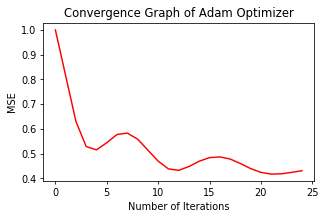

In [45]:
figure(num=None, figsize=(5, 3), dpi=70, facecolor='w', edgecolor='r')
plt.plot(range(len(history_adam)), history_adam, 'r')
plt.title("Convergence Graph of Adam Optimizer")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.show()

###Nadam

In [47]:
print(" *********** Start ************ ")
print(" *********** Adam ************ ")
t_start = time.time()

rdd = sc.parallelize(data) 
w = np.zeros(X.shape[1])
delta = np.zeros(X.shape[1])
m_old = 0
v_old = 0
eta = 1e-2 #3e-2 
b1 = 0.9
b2 = 0.999
gamma = 0.9
n_iter = 25 
history_Nadam = []
error = sc.accumulator(0)
w_br = sc.broadcast(w)
epsilon = 1e-8

for i in range(n_iter):
    error = sc.accumulator(0)
    grad = rdd.map(lambda x : gradient_descent_computation(x , w_br.value))
    grad = grad.reduce(lambda x,y : (x+y)) / n 
    loss = error.value/n
    history_Nadam.append(loss)
    m = b1 * m_old + (1-b1) * grad 
    v = b2 * v_old + (1-b2) * grad**2
    m_hat = m / (1 - b1)
    v_hat = v / (1 - b1)
    u = np.maximum(b2 * v_old, np.abs(grad))
    v_old = v
    m_old = m
    w -= (eta / (np.sqrt(v_hat)+ epsilon)) * (b1 * m_hat + ((1-b1)* grad)/(1-b1))
    w_br = sc.broadcast(w)
    print("Iteration : {}/{} ; Loss = {:.4f}".format(i, n_iter, loss))
        
print(" *********** Ended in ************ ", time.time() - t_start )

*********** Start ************ 
 *********** Adam ************ 
Iteration : 0/25 ; Loss = 1.0000
Iteration : 1/25 ; Loss = 0.7492
Iteration : 2/25 ; Loss = 0.5962
Iteration : 3/25 ; Loss = 0.5190
Iteration : 4/25 ; Loss = 0.5171
Iteration : 5/25 ; Loss = 0.5125
Iteration : 6/25 ; Loss = 0.4996
Iteration : 7/25 ; Loss = 0.4748
Iteration : 8/25 ; Loss = 0.4473
Iteration : 9/25 ; Loss = 0.4263
Iteration : 10/25 ; Loss = 0.4154
Iteration : 11/25 ; Loss = 0.4136
Iteration : 12/25 ; Loss = 0.4169
Iteration : 13/25 ; Loss = 0.4215
Iteration : 14/25 ; Loss = 0.4246
Iteration : 15/25 ; Loss = 0.4256
Iteration : 16/25 ; Loss = 0.4251
Iteration : 17/25 ; Loss = 0.4241
Iteration : 18/25 ; Loss = 0.4232
Iteration : 19/25 ; Loss = 0.4226
Iteration : 20/25 ; Loss = 0.4219
Iteration : 21/25 ; Loss = 0.4210
Iteration : 22/25 ; Loss = 0.4196
Iteration : 23/25 ; Loss = 0.4181
Iteration : 24/25 ; Loss = 0.4164
 *********** Ended in ************ 9.279804468154907

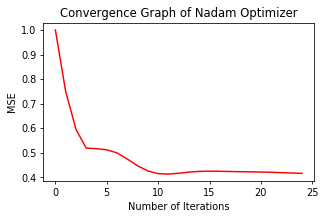

In [48]:
figure(num=None, figsize=(5, 3), dpi=70, facecolor='w', edgecolor='r')
plt.plot(range(len(history_Nadam)), history_Nadam, 'r')
plt.title("Convergence Graph of Nadam Optimizer")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.show()

### Conclusion

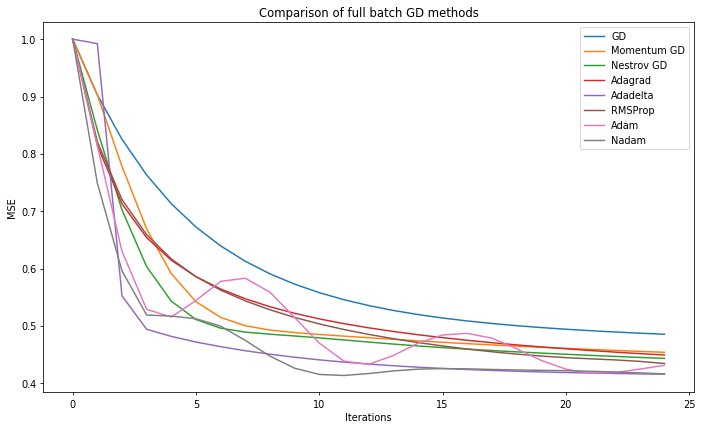

In [50]:
#Comparison of all methods
figure(num=None, figsize=(12, 7), dpi=70, facecolor='w', edgecolor='r')
plt.plot(GD_history, label = 'GD')
plt.plot(momentum_GD, label = 'Momentum GD')
plt.plot(Nestrov_GD, label = 'Nestrov GD') 
plt.plot(history_adagrad, label = 'Adagrad')
plt.plot(history_adadelta, label = 'Adadelta')
plt.plot(history_rmsprop, label = 'RMSProp')
plt.plot(history_adam, label = 'Adam')
plt.plot(history_Nadam, label = 'Nadam')
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('Comparison of full batch GD methods')    
plt.legend();